In [1]:
#Importamos las bibliotecas que usaremos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Leemos el dataset
data = pd.read_csv('data/data.csv',decimal=',',sep=';')
data.head()

,patientcarequeue,appointmentfromtime,DayName,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,...,speciality,patientaddress,gender,email,citypatient,buildingaddress,healthcoverage,buildingcity,medereentity,firsttime
0,422.104,4/1/2021 08:48,Monday,0,0,4,8,False,1,1,...,Pediatría,NaN,F,NaN,Mar del Plata,San Luis 2143,GESTION SALUD S.A. (OSDOP),Mar del plata,90.369,1
1,422.105,4/1/2021 08:49,Monday,0,0,4,8,False,0,1,...,Pediatría,NaN,F,NaN,Mar del Plata,San Luis 2143,GESTION SALUD S.A. (OSDOP),Mar del plata,90.369,0
2,422.109,4/1/2021 08:58,Monday,0,0,4,8,False,1,2,...,Pediatría,LIBERTAD 5354,F,lula_adn@hotmail.com,Mar del Plata,San Luis 2176,OSDEPYM,Mar del plata,78.015,1
3,417.480,4/1/2021 09:00,Monday,0,0,4,9,False,1,11,...,Pediatría,CATAMARA 4337,F,estefaniacoria@hotmail.com,Mar del Plata,San Luis 2176,OSDEPYM,Mar del plata,14.948,1
4,418.219,4/1/2021 09:00,Monday,0,0,4,9,False,1,81,...,Cirugía gral. adultos,NaN,M,NaN,Mar del Plata,San Luis 2176,IOMA,Mar del plata,87.963,1


In [3]:
data['day'] = data['day'].fillna(0).astype(int)
data['hour'] = data['hour'].fillna(0).astype(int)
data['age'] = data['age'].fillna(0).astype(int)
data['firsttime'] = data['firsttime'].fillna(0).astype(int)
data['priordayholiday'] = data['priordayholiday'].fillna(0).astype(int)
data['nextdayholiday'] = data['nextdayholiday'].fillna(0).astype(int)

df_obj = data.select_dtypes(['object'])
data[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113139 entries, 0 to 113138
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   patientcarequeue     113139 non-null  object
 1   appointmentfromtime  113139 non-null  object
 2   DayName              113139 non-null  object
 3   priordayholiday      113139 non-null  int32 
 4   nextdayholiday       113139 non-null  int32 
 5   day                  113139 non-null  int32 
 6   hour                 113139 non-null  int32 
 7   outofschedule        113139 non-null  bool  
 8   appointmentstate     113139 non-null  int64 
 9   age                  113139 non-null  int32 
 10  daysbeforereserved   113139 non-null  int64 
 11  speciality           113139 non-null  object
 12  patientaddress       87430 non-null   object
 13  gender               113139 non-null  object
 14  email                74500 non-null   object
 15  citypatient          113139 non-nu

In [4]:
import re

regex = re.compile(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+')

def isValid(email):
    try:
        if re.fullmatch(regex, email):
          return 1 
        else:
          return 0
    except:
        return 0

data['emailvalid'] = data.apply(lambda x:isValid(x['email']),axis=1)

data.loc[data['healthcoverage'].isna(),'healthcoverage']= 'Sin OS' 
data.loc[data['healthcoverage'] != 'Sin OS','healthcoverage']= 'Con OS' 

In [5]:
data['endofmonth'] = 0
data.loc[data['day'] > 27,'endofmonth'] = 1

In [6]:
# Limito a Mar del Plata y Pediatría
data = data.loc[(data['citypatient'] == 'Mar del Plata') & (data['speciality'] == 'Pediatría')]

# Borro columnas que no voy a usar 
data = data.drop(['medereentity','patientcarequeue','email','patientaddress','buildingcity','buildingaddress','citypatient','speciality'], axis=1)

# Creo una columna datetime para luego mergear con weather
data['datetime'] = pd.to_datetime(data.loc[:,'appointmentfromtime'],dayfirst=True).dt.date

# Borro duplicados
data.drop_duplicates(inplace = True)

# Borro todos los casos mayores a 18 años
data.drop(data.loc[data.age>18].index, inplace=True)

# Borro todos los casos mayores a 18 años
data.drop(data.loc[data.daysbeforereserved<0].index, inplace=True)

# Reinicio el índice
data.reset_index(drop=True, inplace=True)

# Cambio la columna outofschedule a 0/1
data.outofschedule=np.where(data.outofschedule==True,1,0)

data.shape

(41150, 16)

In [7]:
weather = pd.read_csv('data/mdq_weather.csv')
weather.head()

,datetime,tempmax,tempmin,temp,feelslike,humidity,precip,precipprob,precipcover,preciptype,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions
0,2021-01-01,24.9,10.8,17.7,17.7,63.0,0.0,0.0,0.00,NaN,NaN,33.5,1014.5,9.9,389.6,10,Partially cloudy
1,2021-01-02,33.2,12.2,22.8,22.8,59.7,0.0,0.0,0.00,NaN,NaN,24.1,1014.6,10.0,379.2,10,Clear
2,2021-01-03,34.6,17.8,24.7,24.8,63.5,0.0,0.0,0.00,NaN,NaN,27.7,1013.4,9.5,359.0,10,Partially cloudy
3,2021-01-04,23.8,17.9,20.6,20.6,87.7,0.0,0.0,0.00,NaN,NaN,24.9,1013.0,7.4,147.3,5,Overcast
4,2021-01-05,20.8,18.1,19.3,19.3,94.5,5.0,100.0,8.33,rain,NaN,37.1,1013.6,3.5,209.1,6,"Rain, Overcast"


In [8]:
weather['datetime'] = pd.to_datetime(weather.loc[:,'datetime']).dt.date
weather.head()

,datetime,tempmax,tempmin,temp,feelslike,humidity,precip,precipprob,precipcover,preciptype,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions
0,2021-01-01,24.9,10.8,17.7,17.7,63.0,0.0,0.0,0.00,NaN,NaN,33.5,1014.5,9.9,389.6,10,Partially cloudy
1,2021-01-02,33.2,12.2,22.8,22.8,59.7,0.0,0.0,0.00,NaN,NaN,24.1,1014.6,10.0,379.2,10,Clear
2,2021-01-03,34.6,17.8,24.7,24.8,63.5,0.0,0.0,0.00,NaN,NaN,27.7,1013.4,9.5,359.0,10,Partially cloudy
3,2021-01-04,23.8,17.9,20.6,20.6,87.7,0.0,0.0,0.00,NaN,NaN,24.9,1013.0,7.4,147.3,5,Overcast
4,2021-01-05,20.8,18.1,19.3,19.3,94.5,5.0,100.0,8.33,rain,NaN,37.1,1013.6,3.5,209.1,6,"Rain, Overcast"


In [9]:
data_merge = data.merge(weather, on='datetime',how='left')
data_merge['preciptype'] = data_merge['preciptype'].fillna(value='no rain').astype(str)
data_merge['windgust'] = data_merge['windgust'].fillna(0.0).astype(float)
data_merge['sealevelpressure'] = data_merge['sealevelpressure'].fillna(1016.4).astype(float)
data_merge.head()

,appointmentfromtime,DayName,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,daysbeforereserved,...,precipprob,precipcover,preciptype,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions
0,4/1/2021 08:48,Monday,0,0,4,8,0,1,1,0,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast
1,4/1/2021 08:49,Monday,0,0,4,8,0,0,1,0,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast
2,4/1/2021 08:58,Monday,0,0,4,8,0,1,2,0,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast
3,4/1/2021 09:00,Monday,0,0,4,9,0,1,11,18,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast
4,4/1/2021 09:20,Monday,0,0,4,9,0,1,2,0,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast


In [10]:
data_merge['llovio'] = data_merge.apply(lambda x: 1 if x.precip>0 else 0, axis=1)

In [11]:
data_merge.appointmentstate.value_counts(normalize=True)

1    0.793001
0    0.206999
Name: appointmentstate, dtype: float64

In [12]:
data_merge.llovio.value_counts(normalize=True)

0    0.766027
1    0.233973
Name: llovio, dtype: float64

In [13]:
data_final=data_merge.drop(data_merge.loc[(data_merge['appointmentstate'] == 1)].sample(20000).index)
data_final = data_final.drop(['datetime'], axis=1)

data_final.appointmentstate.value_counts(normalize=True)

1    0.597258
0    0.402742
Name: appointmentstate, dtype: float64

In [14]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21150 entries, 0 to 41149
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appointmentfromtime  21150 non-null  object 
 1   DayName              21150 non-null  object 
 2   priordayholiday      21150 non-null  int32  
 3   nextdayholiday       21150 non-null  int32  
 4   day                  21150 non-null  int32  
 5   hour                 21150 non-null  int32  
 6   outofschedule        21150 non-null  int32  
 7   appointmentstate     21150 non-null  int64  
 8   age                  21150 non-null  int32  
 9   daysbeforereserved   21150 non-null  int64  
 10  gender               21150 non-null  object 
 11  healthcoverage       21150 non-null  object 
 12  firsttime            21150 non-null  int32  
 13  emailvalid           21150 non-null  int64  
 14  endofmonth           21150 non-null  int64  
 15  tempmax              21150 non-null 

In [15]:
data_final.llovio.value_counts(normalize=True)

0    0.761797
1    0.238203
Name: llovio, dtype: float64

In [16]:
data_final.head()

,appointmentfromtime,DayName,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,daysbeforereserved,...,precipcover,preciptype,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions,llovio
0,4/1/2021 08:48,Monday,0,0,4,8,0,1,1,0,...,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0
1,4/1/2021 08:49,Monday,0,0,4,8,0,0,1,0,...,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0
5,4/1/2021 09:20,Monday,0,0,4,9,0,1,1,18,...,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0
7,4/1/2021 09:40,Monday,0,0,4,9,0,0,1,19,...,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0
8,4/1/2021 10:00,Monday,0,0,4,10,0,1,11,0,...,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0


In [17]:
data_final.describe()

,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,daysbeforereserved,firsttime,emailvalid,...,precip,precipprob,precipcover,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,llovio
count,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,...,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000
mean,0.000615,0.039811,15.471868,13.809504,0.240993,0.597258,6.238156,14.900047,0.409504,0.677967,...,2.275631,23.820331,2.185781,22.995050,27.011967,1016.083149,8.900118,192.890624,6.359291,0.238203
std,0.024785,0.195519,8.722967,2.996392,0.427696,0.490461,4.833163,15.161093,0.491754,0.467267,...,7.186207,42.599422,6.753452,24.871898,7.977934,5.693120,1.586790,104.395328,2.431751,0.425994
min,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.400000,999.100000,1.900000,12.600000,1.000000,0.000000
25%,0.000000,0.000000,8.000000,11.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,22.300000,1012.000000,8.400000,102.750000,4.000000,0.000000
50%,0.000000,0.000000,15.000000,14.000000,0.000000,1.000000,5.000000,12.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,25.900000,1016.300000,9.700000,171.500000,6.000000,0.000000
75%,0.000000,0.000000,23.000000,17.000000,0.000000,1.000000,10.000000,24.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,47.200000,31.700000,1020.200000,10.000000,285.600000,8.000000,0.000000
max,1.000000,1.000000,31.000000,19.000000,1.000000,1.000000,18.000000,180.000000,1.000000,1.000000,...,52.000000,100.000000,91.670000,83.500000,61.200000,1030.600000,10.900000,420.200000,10.000000,1.000000


In [18]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21150 entries, 0 to 41149
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appointmentfromtime  21150 non-null  object 
 1   DayName              21150 non-null  object 
 2   priordayholiday      21150 non-null  int32  
 3   nextdayholiday       21150 non-null  int32  
 4   day                  21150 non-null  int32  
 5   hour                 21150 non-null  int32  
 6   outofschedule        21150 non-null  int32  
 7   appointmentstate     21150 non-null  int64  
 8   age                  21150 non-null  int32  
 9   daysbeforereserved   21150 non-null  int64  
 10  gender               21150 non-null  object 
 11  healthcoverage       21150 non-null  object 
 12  firsttime            21150 non-null  int32  
 13  emailvalid           21150 non-null  int64  
 14  endofmonth           21150 non-null  int64  
 15  tempmax              21150 non-null 

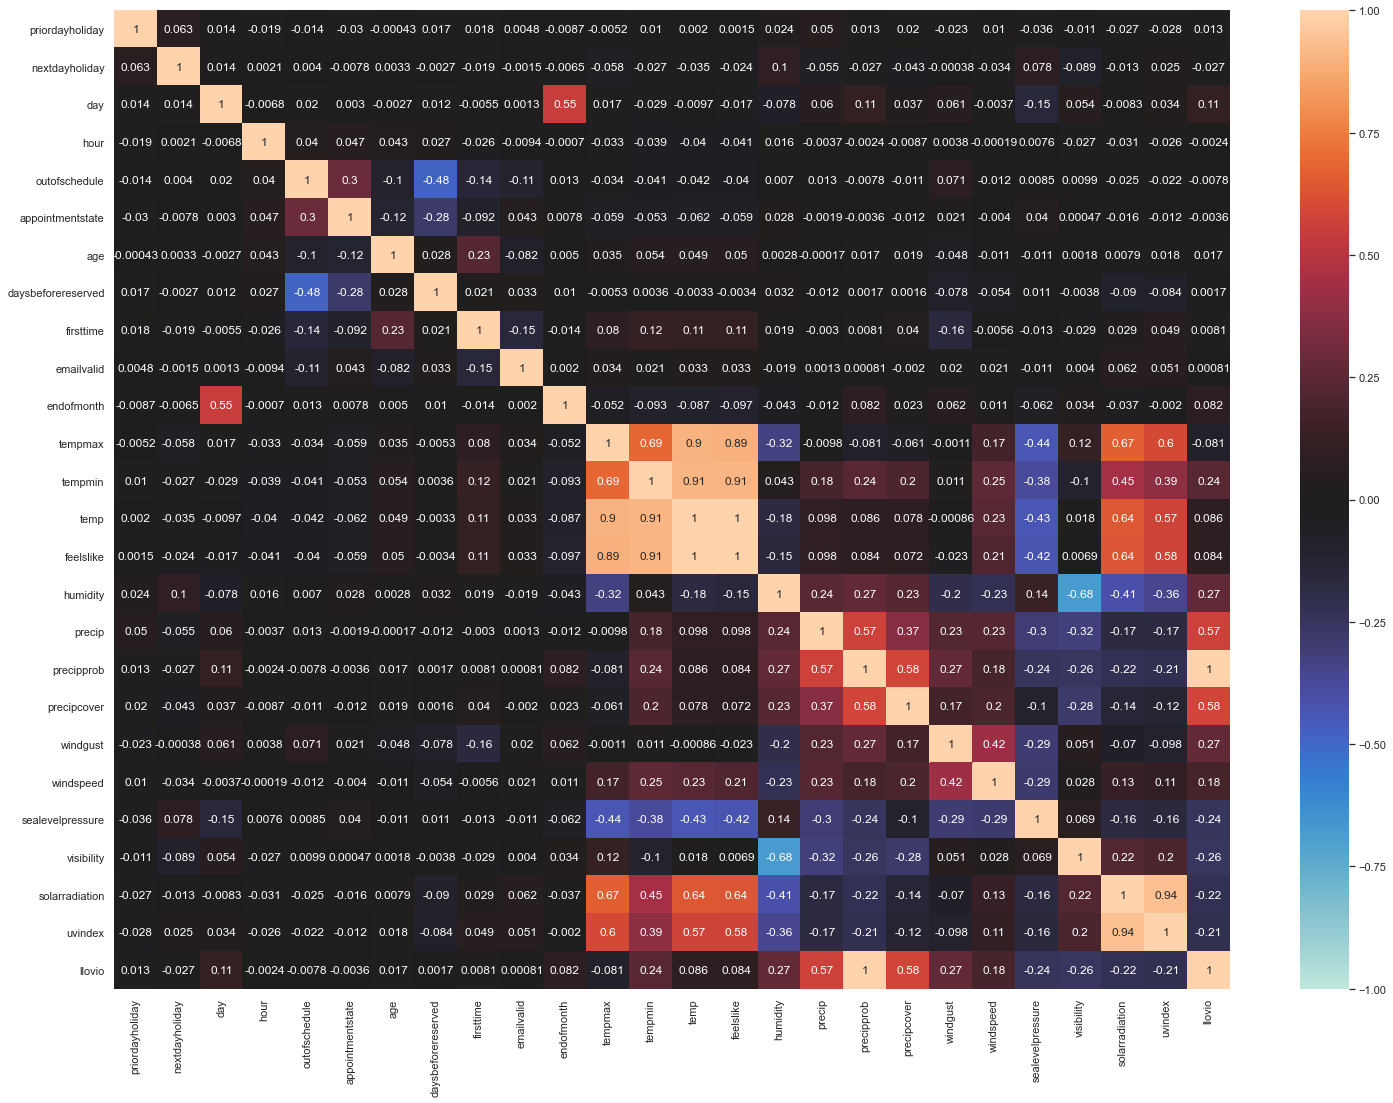

In [19]:
# visualizamos la matriz de correlación en Seaborn usando a heatmap
sns.set(rc = {'figure.figsize':(25,18)})
sns.heatmap(data_final.corr(), vmin=-1, vmax=1, center=0, annot=True);

<AxesSubplot:>

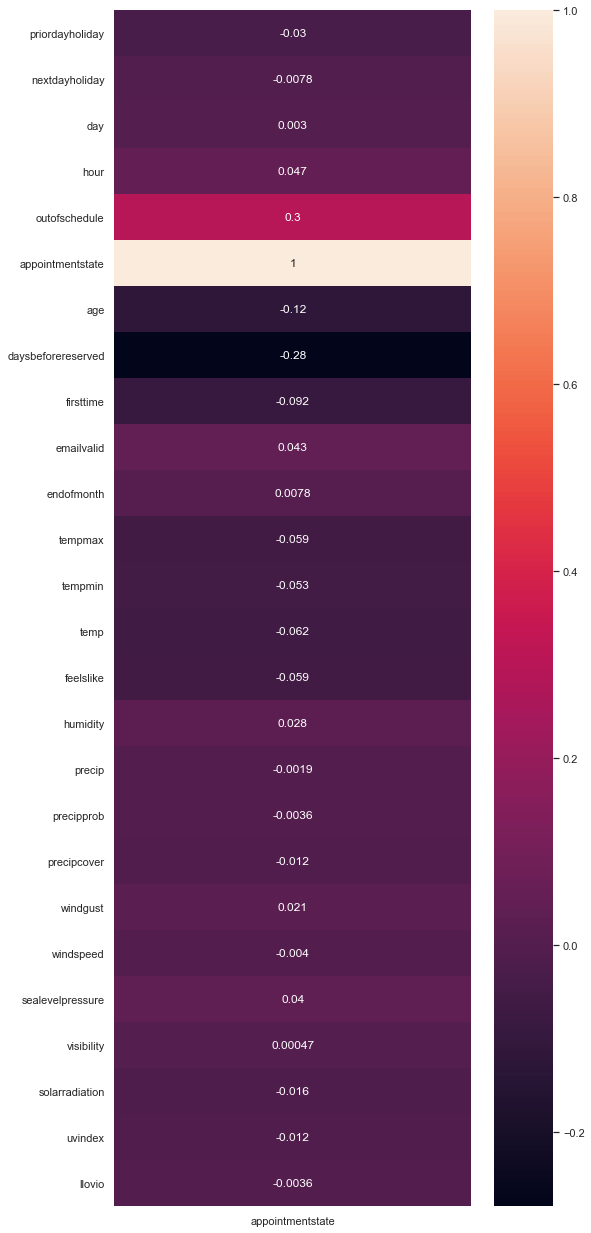

In [20]:
plt.figure(figsize=(8,22))
sns.heatmap(data_final.corr()[['appointmentstate']], annot=True)

In [21]:
data_final.to_csv("Data/dataset_turnos.csv")